In [152]:
import pandas as pd
import numpy as np
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

In [2]:
posters = io.loadmat("../data/posters.mat")

In [3]:
movies = pd.read_csv("../data/movies_with_words.csv")
movies.head()

,adult,backdrop_path,id,original_language,original_title,overview,popularity,poster_path,release_date,title,...,music,which,soon,know,them,wing,comedy,form,test,mall
0,0,/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg,299536,en,Avengers: Infinity War,as the avengers and their allies have continue...,153.811,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,2018-04-25,Avengers: Infinity War,...,0,0,0,0,1,0,0,0,0,0
1,0,/5zfVNTrkhMu673zma6qhFzG01ig.jpg,300668,en,Annihilation,a biologist signs up for a dangerous secret e...,29.516,/d3qcpfNwbAMCNqWDHzPQsUYiUgS.jpg,2018-02-22,Annihilation,...,0,0,0,0,0,0,0,0,0,0
2,0,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,299782,en,The Other Side of the Wind,surrounded by fans and skeptics grizzled dire...,6.820,/kFky1paYEfHxfCYByEc9g7gn6Zk.jpg,2018-11-02,The Other Side of the Wind,...,0,0,0,0,0,0,0,0,0,0
3,0,/q9hnJ9SzwcF30seRtXEzLd5l1gw.jpg,351044,en,Welcome to Marwen,when a devastating attack shatters mark hoganc...,61.973,/o45VIAUYDcVCGuzd43l8Sr5Dfti.jpg,2018-12-21,Welcome to Marwen,...,0,0,0,1,0,0,0,0,1,0
4,0,/AmO8I38bkHwKhgxPNrd6djBQyPU.jpg,361292,en,Suspiria,a darkness swirls at the center of a world ren...,41.461,/dzWTnkert9EoiPWldWJ15dnfAFl.jpg,2018-10-11,Suspiria,...,0,0,0,0,0,0,0,0,0,0


In [4]:
"rating" in movies.columns

True

In [5]:
all_ids = [str(i) for i in movies["id"] if str(i) in posters and posters[str(i)].shape == (92, 140, 3)]

In [6]:
len(np.unique(all_ids)) - len(all_ids)

-746

In [7]:
ids = np.unique(all_ids)

In [8]:
X = np.stack([posters[i] for i in ids])

movies_by_id = movies.set_index("id")
y = np.stack([int(movies_by_id.loc[int(i),"rating"].iloc[0]) if type(movies_by_id.loc[int(i),"rating"]) \
              == pd.Series else int(movies_by_id.loc[int(i),"rating"]) for i in ids])

In [9]:
X.shape

(1697, 92, 140, 3)

In [10]:
y.shape

(1697,)

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [34]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(np.arange(11))
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [37]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [122]:
# Importing all necessary libraries 
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score

In [20]:
epochs = 10
batch_size = 16
img_size = (92, 140)
input_shape = img_size + (3,)

In [74]:
def first_nn_model():
    model = Sequential() 
    model.add(Conv2D(32, (2, 2), input_shape=input_shape)) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Conv2D(32, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Conv2D(64, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Flatten()) 
    model.add(Dense(64)) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(dummy_y.shape[1])) 
    model.add(Activation('sigmoid'))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])

    return model

In [98]:
def run_keras_cv(model_fn, X=X_train, y=y_train, epochs=10, batch_size=16, error_fn=mae, seed=42):
    np.random.seed(seed)
    estimator = KerasClassifier(build_fn=model_fn, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = KFold(n_splits=5, shuffle=True)
    scorer = lambda e, X, y: error_fn(np.argmax(y, axis=1), e.predict(X))
    results = cross_val_score(estimator, X, y, cv=kfold, n_jobs=-1, scoring=scorer)
    return estimator, results

In [76]:
%%time
first_estimator, first_results = run_keras_cv(first_nn_model)

CPU times: user 107 ms, sys: 118 ms, total: 225 ms
Wall time: 4min 44s


In [77]:
first_results.mean(), first_results.std()

(4.7474108383510885, 1.453609477981959)

In [97]:
def get_errors(estimator, X=X_train, y=y_train, Xt=None, yt=None, test=False, seed=42):
    np.random.seed(seed)
    estimator.fit(X, y)
    if test:
        pred = estimator.predict(Xt)
        return mae(np.argmax(yt, axis=1), pred), rmse(np.argmax(yt, axis=1), pred)
    else:
        pred = estimator.predict(X)
        return mae(np.argmax(y, axis=1), pred), rmse(np.argmax(y, axis=1), pred)

In [100]:
get_errors(first_estimator)

(2.5754716981132075, 3.0266115308196664)

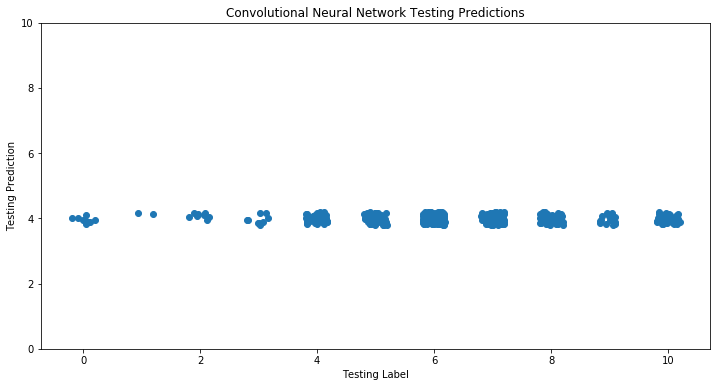

In [168]:
first_pred = first_estimator.predict(X_test)

x_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
plt.figure(figsize=[12,6])
plt.scatter(y_test_labels + x_jitter, first_pred + y_jitter)
plt.xlabel("Testing Label")
plt.ylabel("Testing Prediction")
plt.title("Convolutional Neural Network Testing Predictions")
plt.ylim([0,10])
plt.savefig("../figures/cnn_all_fours.png");

nn with flattened data?

In [99]:
flattened_shape = (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
flattened_X_train = X_train.reshape(flattened_shape)
flattened_X_test = X_test.reshape((X_test.shape[0], flattened_shape[1]))

In [84]:
def second_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [101]:
%%time
second_estimator, second_results = run_keras_cv(second_nn_model, X=flattened_X_train)

CPU times: user 104 ms, sys: 150 ms, total: 254 ms
Wall time: 13.1 s


In [102]:
second_results.mean(), second_results.std()

(2.9173104832484174, 1.9265216813213943)

In [105]:
get_errors(second_estimator, X=flattened_X_train)

(2.1446540880503147, 2.715550374505689)

In [113]:
def third_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [107]:
%%time
third_estimator, third_results = run_keras_cv(third_nn_model, X=flattened_X_train)

CPU times: user 44.4 ms, sys: 32.3 ms, total: 76.6 ms
Wall time: 14.7 s


In [108]:
third_results.mean(), third_results.std()

(4.389979928979466, 1.662370389877224)

In [110]:
get_errors(third_estimator, X=flattened_X_train)

(1.6666666666666667, 2.2695689890872264)

In [120]:
def fourth_nn_model():
    model = Sequential()
    model.add(Dense(8, input_dim=flattened_shape[1], activation="relu"))
    model.add(Dropout(0.25, seed=42))
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [114]:
%%time
fourth_estimator, fourth_results = run_keras_cv(fourth_nn_model, X=flattened_X_train)

CPU times: user 78.6 ms, sys: 88.3 ms, total: 167 ms
Wall time: 12.4 s


In [115]:
fourth_results.mean(), fourth_results.std()

(4.214732129072101, 1.5027730742846714)

In [117]:
get_errors(fourth_estimator, X=flattened_X_train)

(6.122641509433962, 6.473215253895891)

In [149]:
fourth_estimator.predict(flattened_X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,

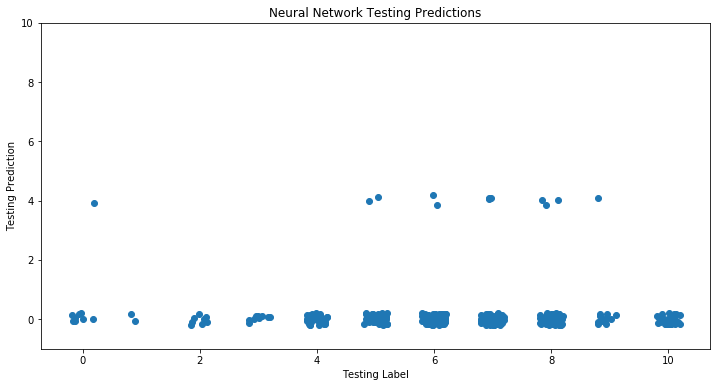

In [170]:
fourth_pred = fourth_estimator.predict(flattened_X_test)

x_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test_labels))
plt.figure(figsize=[12,6])
plt.scatter(y_test_labels + x_jitter, fourth_pred + y_jitter)
plt.xlabel("Testing Label")
plt.ylabel("Testing Prediction")
plt.title("Neural Network Testing Predictions")
plt.ylim([-1,10])
plt.savefig("../figures/nn_most_zeros.png");

In [141]:
def fifth_nn_model():
    model = Sequential()
    model.add(Conv2D(64, (2,2), input_shape=input_shape, activation="relu"))
    model.add(Dropout(0.25, seed=42))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [142]:
%%time
fifth_estimator, fifth_results = run_keras_cv(fifth_nn_model)

CPU times: user 132 ms, sys: 148 ms, total: 280 ms
Wall time: 11min 17s


In [143]:
fifth_results.mean(), fifth_results.std()

(3.326252894858731, 2.0300634989517286)

In [144]:
get_errors(fifth_estimator)

(2.5754716981132075, 3.0266115308196664)

In [147]:
fifth_estimator.predict(X_test)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [179]:
def make_nn(*n_nodes, output_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(n_nodes[0], input_dim=flattened_shape[1], activation="relu"))
    
    for i in n_nodes[1:]:
        model.add(Dense(i, activation="relu"))
    
    model.add(Dense(y_train.shape[1], activation=output_activation))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["mae", "mse"])
    return model

In [ ]:
%%time
sixth_estimator, sixth_results = run_keras_cv(
    lambda: make_nn(128, 64, 32, 16, output_activation="sigmoid"), X=flattened_X_train)